In [139]:
#####Timescale Poisson Factorization#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [140]:
####データの発生####
##データの設定
k = 10   #基底数
hh = 5000   #ユーザー数
item = 3000   #アイテム数
pt = np.random.poisson(np.random.gamma(22.5, 1/0.2, hh), hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)   #
vec_k = np.repeat(1, k)

In [141]:
##IDとインデックスを設定
#IDを設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
user_vec = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
    user_vec[i] = np.repeat(1, pt[i])

In [142]:
##アイテムの割当を生成
#セグメント割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(2.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
    
#インデックスの設定
item_list = [j for j in range(item)]
item_vec = [j for j in range(item)]
item_n = np.repeat(0, item)
for j in range(item):
    item_list[j] = index[item_id==j]
    item_vec[j] = np.repeat(1, len(item_list[j]))
    item_n[j] = len(item_list[j])

0
1000
2000
3000
4000


In [143]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k1 = 3; k2 = 5; k3 = 5
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
col_u = u.shape[1]

#アイテムの説明変数を生成
k1 = 4; k2 = 5; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
col_v = v.shape[1]

In [314]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    
    #ガンマ分布から継続時間を生成
    alpha1 = 20.0
    alpha2 = 0.15
    period = np.array(np.random.gamma(alpha1, 1/alpha2, hh), dtype="int")
    period_vec = period[user_id].reshape(hhpt, 1)
    
    ##ランダム効果のパラメータを生成
    #階層モデルのパラメータを生成
    tau1 = 0.3; tau2 = 0.3
    alpha1 = np.random.normal(0, 0.4, col_u)
    alpha2 = np.random.normal(0, 0.4, col_v)
    taut1 = tau1; taut2 = tau2
    alphat1 = alpha1.copy(); alphat2 = alpha2.copy()
    
    #正規分布からランダム効果を生成
    lambda1 = np.dot(u, alpha1)
    lambda2 = np.dot(v, alpha2)
    w1 = lambda1 + np.random.normal(0, tau1, hh)
    w2 = lambda2 + np.random.normal(0, tau2, item)
    wt1 = w1.copy(); wt2 = w2.copy()

    ##NMFのパラメータを生成
    #ガンマ分布の尺度パラメータを生成
    alpha_u = np.random.normal(0, 0.4, k*col_u).reshape(col_u, k)
    alpha_v = np.random.normal(0, 0.4, k*col_v).reshape(col_v, k)
    alpha_ut = alpha_u; alpha_vt = alpha_v
    lambda_u = np.exp(np.dot(u, alpha_u))
    lambda_v = np.exp(np.dot(v, alpha_v))

    #ガンマ分布の形状パラメータを生成
    beta_u = np.abs(np.random.normal(1.0, 0.5, 1))
    beta_v = np.abs(np.random.normal(1.0, 0.5, 1))
    beta_ut = beta_u; beta_vt = beta_v

    #ガンマ分布から行列分解のパラメータを生成
    theta_u = np.random.gamma(lambda_u, 1/beta_u)
    theta_v = np.random.gamma(lambda_v, 1/beta_v)
    theta_ut = theta_u; theta_vt = theta_v

    ##指数分布から応答変数を生成
    dim = 100
    WH = np.exp(w1[user_id] + w2[item_id]) + np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)
    y_dt = np.zeros((hhpt, dim))
    for j in range(dim):
        y_dt[:, j] = np.random.exponential(WH, hhpt)
    y = np.sum(np.cumsum(y_dt, axis=1) < period[user_id].reshape(hhpt, 1), axis=1)
    y_vec = y.reshape(hhpt, 1)
    
    #break条件
    print(np.array([rp, np.max(y), np.sum(y==0)]))
    if (np.max(y) < 100) & (np.max(y) > 25) & (np.sum(y==0) > 75000) & (np.sum(y==0) < 200000):
        break

[  1 100 468]
[   2  100 7386]
[   3  100 3220]
[    4    99 85512]


1513524
2.7101549965619984


(array([5.45974e+05, 1.19310e+04, 4.91000e+02, 5.20000e+01, 1.00000e+01,
        5.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

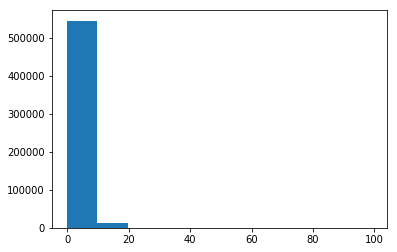

In [315]:
#生成した応答変数を確認
print(np.sum(y))
print(np.mean(y))
plt.hist(y)

In [316]:
####マルコフ連鎖モンテカルロ法でMixed effect Poisson Factorizationを推定####
##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha, beta, tau_inv, d, d_log, x):

    #ガンマ回帰モデルの対数尤度
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = np.sum(beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log)

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(alpha, tau_inv), alpha)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

In [317]:
#ガンマ回帰の対数事後分布の微分関数
def dloglike_alpha(alpha, beta, tau_inv, d, d_log, x, n):

    #期待値の設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.sum(((d-Lambda) / (np.power(Lambda, 2)/beta) * Lambda).reshape(n, 1) * x, axis=0)
    dmvn = np.dot(-tau_inv, alpha)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

In [318]:
#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, tau_inv, d, d_log, x, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, tau_inv, d, d_log, x, n) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, tau_inv, d, d_log, x, n) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [319]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k):

    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #ガンマ回帰モデルの対数尤度
    Lho1 = np.sum(beta_u * (-d1/Lambda_u - mu_u) + beta_u*np.log(beta_u) - math.lgamma(beta_u) + (beta_u-1)*d_log1)
    Lho2 = np.sum(beta_v * (-d2/Lambda_v - mu_v) + beta_v*np.log(beta_v) - math.lgamma(beta_v) + (beta_v-1)*d_log2)

    #対数事後分布の和
    LL = Lho1 + Lho2
    return LL

In [320]:
#形状パラメータの微分関数
def dloglike_beta(beta, alpha_u, alpha_v, d1, d2, u, v, hh, item, k):
    
    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #微分関数の和
    dlgamma_u = (hh*k)*(np.log(beta_u) - scipy.special.digamma(beta_u)) + np.sum(1 - d1/Lambda_u + np.log(d1/Lambda_u))
    dlgamma_v = (item*k)*(np.log(beta_v) - scipy.special.digamma(beta_v)) + np.sum(1 - d2/Lambda_v + np.log(d2/Lambda_v))
    dlgamma = -np.append(dlgamma_u, dlgamma_v)
    return dlgamma

In [321]:
#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [322]:
##アルゴリズムの設定
R = 2000
keep = 4
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.0025
L = 3

In [323]:
##事前分布の設定
#モデルパラメータの事前分布
gamma_u = np.repeat(0, col_u)
gamma_v = np.repeat(0, col_v)
tau_inv1 = np.linalg.inv(np.diag(np.repeat(100, col_u)))
tau_inv2 = np.linalg.inv(np.diag(np.repeat(100, col_v)))
tau_inv = np.linalg.inv(np.diag(np.repeat(100, k)))

#ハイパーパラメータの設定
par = 200
omega1 = par/pt.reshape(hh, 1); omega1[omega1 < 1, ] = 1
omega2 = par/item_n.reshape(item, 1); omega2[omega2 < 1] = 1

In [389]:
##パラメータの真値
#ランダム効果の真値
alpha1 = alphat1; alpha2 = alphat2
tau1 = taut1; tau2 = taut2
w1 = wt1; w2 = wt2

#ガンマ分布の尺度パラメータの真値
alpha_u = alpha_ut; alpha_v = alpha_vt
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))

#ガンマ分布の形状パラメータの真値
beta_u = beta_ut
beta_v = beta_vt

#行列分解のパラメータの真値
theta_u = theta_ut
theta_v = theta_vt
WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   #期待値

In [390]:
####MCMCでパラメータをサンプリング####

##ユーザー特徴行列をサンプリング
#補助変数gammaを更新
theta_vec2 = theta_v[item_id, ]
gamma = (theta_u[user_id, ] * theta_vec2) / WH.reshape(hhpt, 1)

#ユーザーごとのガンマ分布のパラメータを設定
gamma_y = gamma * y_vec   #要素ごとの期待値
gamma_x = gamma * np.exp(w1[user_id] + w2[item_id]).reshape(hhpt, 1)
W1 = np.zeros((hh, k)); W2 = np.zeros((hh, k))
for i in range(hh):
    W1[i, ] = np.dot(gamma_y[user_list[i], ].T, user_vec[i]) 
    W2[i, ] = np.dot(((gamma_x[user_list[i], ] + theta_vec2[user_list[i], ]) / (period_vec[user_list[i], ])).T, user_vec[i])
    #W2[i, ] = np.dot(theta_vec2[user_list[i], ].T, user_vec[i])

In [391]:
#ガンマ分布よりパラメータをサンプリング
theta_u = np.random.gamma(W1, 1 / W2)

In [392]:
i = 3
print(np.round(theta_u[i, ], 3))
print(np.round(theta_ut[i, ], 3))

[ 3.07   5.077 10.073  6.478  4.308  4.449 16.708 18.421  6.628  8.969]
[0.559 1.962 3.312 1.463 1.447 0.617 7.12  5.282 2.637 2.009]


In [296]:
i = 3
print(np.round(theta_u[i, ], 3))
print(np.round(theta_ut[i, ], 3))

[0.668 1.563 1.108 0.453 0.267 0.286 0.199 0.709 1.94  0.78 ]
[0.995 0.016 3.522 0.24  0.08  3.137 1.359 1.957 0.345 0.498]


In [427]:
i  = 1112
50
print((np.exp(wt1[user_id] + wt2[item_id]) + np.dot(theta_ut[user_id, ] * theta_vt[item_id, ], vec_k))[i])
print(y[i])
print(period[user_id][i])
print(1 / (np.exp(wt1[user_id] + wt2[item_id]) + np.dot(theta_ut[user_id, ] * theta_vt[item_id, ], vec_k))[i])
print(y[i] / period[user_id][i])
print(period[user_id][i] / y[i])

64.87512748772312
1
88
0.01541422789788334
0.011363636363636364
88.0


C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([inf, inf, inf, ..., inf, inf, inf])